In [13]:
import warnings

# Ignore Deprecation warnings for this code cell
warnings.filterwarnings("ignore",)



In [14]:
!pip install opencv-python

In [15]:
pip install matplotlib

DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\apache_beam-2.52.0rc2-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\avro_python3-1.10.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\contextlib2-21.6.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\cython-3.0.5-py3.11.egg is deprecated. p

In [16]:
pip install mysql-connector-python

  Using cached mysql_connector_python-8.2.0-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached protobuf-4.21.12-cp310-abi3-win_amd64.whl (527 kB)
Using cached mysql_connector_python-8.2.0-cp311-cp311-win_amd64.whl (14.2 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.0
    Uninstalling protobuf-4.25.0:
      Successfully uninstalled protobuf-4.25.0
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\apache_beam-2.52.0rc2-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\avro_python3-1.10.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\contextlib2-21.6.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at d:\tfod\tfodcourse\tfod\lib\site-packages\cython-3.0.5-py3.11.egg is deprecated. p

In [17]:
import cv2 as cv
import matplotlib.pyplot as plt
import mysql.connector

In [18]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") ## weights

In [19]:
inWidth = 368
inHeight = 368
thr = 0.2

In [20]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist":4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip" : 8 , "RKnee": 9,
              "RAnkle": 10 , "LHip":11 , "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"] ,["LElbow" , "LWrist"],
              ["Neck" , "RHip"] , ["RHip", "RKnee"], ["RKnee", "RAnkle"] , ["Neck" , "LHip"],
              ["LHip", "LKnee"] , ["LKnee" , "LAnkle"] , ["Neck" , "Nose"] , ["Nose" , "REye"],
              ["REye" , "REar"] , ["Nose", "LEye"], ["LEye", "LEar"]]

In [8]:
img = cv.imread("Shah_Rukh_Khan.png")

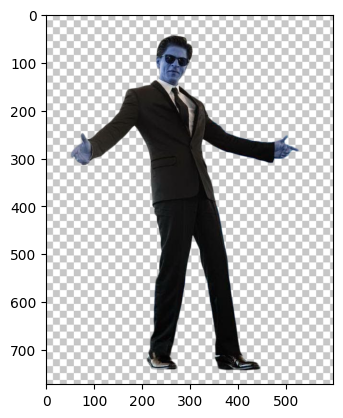

In [9]:
plt.imshow(img) #BGR

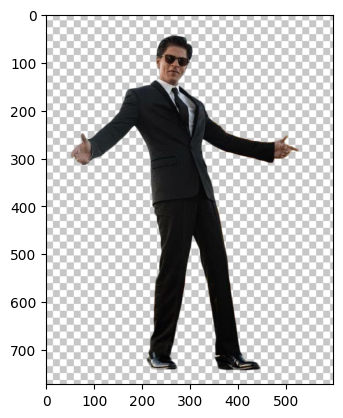

In [10]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [32]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame , 1.0 , (inWidth , inHeight) , (127.5 ,127.5 , 127.5) , swapRB = True , crop = False))
    out = net.forward()
    out = out[:, :19, :, :] # MobileNet Output [1,57 ,-1 ,-1 ] , we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    # Creating Points on Body Part
    for i in range(len(BODY_PARTS)):
        
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i , : , :]
        
        # Originally, we try to find all the loacl maximus. To simplify a sample 
        # we just find a global one . However only a single pose at same time
        # could be detected this way 

        _ ,conf , _,point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0] / out.shape[3])
        y = (frameHeight * point[1] / out.shape[2])
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x) , int(y)) if conf > thr else None)
     # Joining Part
    for pair  in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame , points[idFrom], points[idTo] , (0,255,0) ,3)
            cv.ellipse(frame , points[idFrom] , (3,3), 0, 0, 360 , (0,0,255), cv.FILLED)
            cv.ellipse(frame , points[idTo] , (3,3) , 0, 0, 360 , (0,0,255) , cv.FILLED)
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() /1000
    cv.putText(frame , '%.2fms' % (t / freq) , ( 10 , 20 ) , cv.FONT_HERSHEY_SIMPLEX , 0.5 , ( 0 , 0 , 0 ))
    return frame


       
        
        
        

In [33]:
estimated_img = pose_estimation(img)

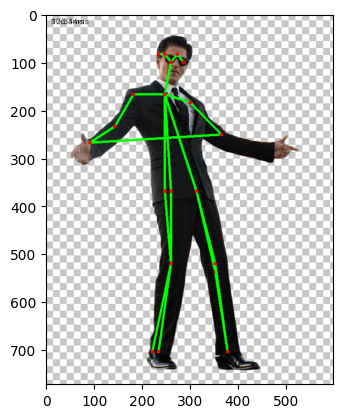

In [34]:
plt.imshow(cv.cvtColor(estimated_img, cv.COLOR_BGR2RGB))

# Perform this demo on video

In [31]:
cap = cv.VideoCapture('demo.mp4')
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")

while cv.waitKey(1) < 0:
    hasFrame , frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame , 1.0 , (inWidth , inHeight) , (127.5 ,127.5 , 127.5) , swapRB = True , crop = False))
    out = net.forward()
    out = out[:, :19, :, :] # MobileNet Output [1,57 ,-1 ,-1 ] , we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    # Creating Points on Body Part
    for i in range(len(BODY_PARTS)):
        
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i , : , :]
        
        # Originally, we try to find all the loacl maximus. To simplify a sample 
        # we just find a global one . However only a single pose at same time
        # could be detected this way 

        _ ,conf , _,point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0] / out.shape[3])
        y = (frameHeight * point[1] / out.shape[2])
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x) , int(y)) if conf > thr else None)
     # Joining Part
    for pair  in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame , points[idFrom], points[idTo] , (0,255,0) ,3)
            cv.ellipse(frame , points[idFrom] , (3,3), 0, 0, 360 , (0,0,255), cv.FILLED)
            cv.ellipse(frame , points[idTo] , (3,3) , 0, 0, 360 , (0,0,255) , cv.FILLED)
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() /1000
    cv.putText(frame , '%.2fms' % (t / freq) , ( 10 , 20 ) , cv.FONT_HERSHEY_SIMPLEX , 0.5 , ( 0 , 0 , 0 ))

    cv.imshow('Pose estimation Video' , frame)
    
    
    

KeyboardInterrupt: 

# Real Time webcame demo

In [21]:
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_FPS,10)
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")

while cv.waitKey(1) < 0:
    hasFrame , frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame , 1.0 , (inWidth , inHeight) , (127.5 ,127.5 , 127.5) , swapRB = True , crop = False))
    out = net.forward()
    out = out[:, :19, :, :] # MobileNet Output [1,57 ,-1 ,-1 ] , we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    # Creating Points on Body Part
    for i in range(len(BODY_PARTS)):
        
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i , : , :]
        
        # Originally, we try to find all the loacl maximus. To simplify a sample 
        # we just find a global one . However only a single pose at same time
        # could be detected this way 

        _ ,conf , _,point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0] / out.shape[3])
        y = (frameHeight * point[1] / out.shape[2])
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x) , int(y)) if conf > thr else None)
     # Joining Part
    for pair  in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame , points[idFrom], points[idTo] , (0,255,0) ,3)
            cv.ellipse(frame , points[idFrom] , (3,3), 0, 0, 360 , (0,0,255), cv.FILLED)
            cv.ellipse(frame , points[idTo] , (3,3) , 0, 0, 360 , (0,0,255) , cv.FILLED)
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() /1000
    cv.putText(frame , '%.2fms' % (t / freq) , ( 10 , 20 ) , cv.FONT_HERSHEY_SIMPLEX , 0.5 , ( 0 , 0 , 0 ))

    cv.imshow('Pose estimation Video' , frame)
    

KeyboardInterrupt: 

 # Pose Estimation of Image and Printing Their Measurement

In [35]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet Output [1, 57, -1, -1], we only need the first 19 elements

    assert (len(BODY_PARTS) == out.shape[1])

    points = []
    # Creating Points on Body Part
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximus. To simplify a sample
        # we just find a global one. However, only a single pose at the same time
        # could be detected this way.

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0] / out.shape[3])
        y = (frameHeight * point[1] / out.shape[2])
        # Add a point if its confidence is higher than the threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    # Joining Parts and calculating body measurements
    measurements = {}
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert (partFrom in BODY_PARTS)
        assert (partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

            # Calculate the distance between body parts and store it in measurements
            distance = ((points[idTo][0] - points[idFrom][0]) ** 2 + (points[idTo][1] - points[idFrom][1]) ** 2) ** 0.5
            measurements[(partFrom, partTo)] = distance

    # Print body measurement values
    for key, value in measurements.items():
        print(f"{key[0]} to {key[1]} distance: {value:.2f} pixels")

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, f'%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame


In [36]:
estimated_img = pose_estimation(img)

Neck to RShoulder distance: 52.00 pixels
Neck to LShoulder distance: 65.00 pixels
LShoulder to LElbow distance: 77.52 pixels
LElbow to LWrist distance: 62.13 pixels
Neck to RHip distance: 202.42 pixels
RHip to RKnee distance: 151.00 pixels
RKnee to RAnkle distance: 185.83 pixels
Neck to LHip distance: 212.51 pixels
LHip to LKnee distance: 155.96 pixels
LKnee to LAnkle distance: 185.83 pixels
Neck to Nose distance: 68.25 pixels
Nose to REye distance: 21.40 pixels
REye to REar distance: 13.00 pixels
Nose to LEye distance: 21.40 pixels


# Body_Measurement_On_Video and stored the measurement into my database.
* Each frame containing BODY_PARTS and POSE_PARTS

In [1]:
import cv2 as cv
import mysql.connector

# Load the pre-trained pose estimation model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Input dimensions and confidence threshold
inWidth = 368
inHeight = 368
thr = 0.2

# Define body parts and pose pairs
BODY_PARTS = {
    "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
    "LEye": 15, "REar": 16, "LEar": 17, "Background": 18
}

POSE_PAIRS = [
    ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"],
    ["Neck", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"],
    ["Neck", "Nose"], ["Nose", "REye"], ["REye", "REar"],
    ["Nose", "LEye"], ["LEye", "LEar"]
]

# Configure the MySQL connection
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="123456789",
    database="myblock"
)
cursor = db.cursor()

# Define the MySQL table for storing body measurements
table_name = "body_measurements"
create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} " \
                    "(id INT AUTO_INCREMENT PRIMARY KEY, " \
                    "video_name VARCHAR(255), " \
                    "measurement_type VARCHAR(255), " \
                    "measurement_value DOUBLE, " \
                    "timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP)"

cursor.execute(create_table_query)
db.commit()

# Specify the video file to process and the video name
video_file = "demo.mp4"
video_name = "video1"  # Change this to the desired video name

cap = cv.VideoCapture(video_file)
cap.set(3, 800)
cap.set(4, 800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError(f"Cannot open video: {video_file}")

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = {}
    measurements = {}

    # Create Points on Body Part
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0] / out.shape[3])
        y = (frameHeight * point[1] / out.shape[2])
        points[i] = (int(x), int(y)) if conf > thr else None

    # Calculate and store the distance between body parts
    for pair in POSE_PAIRS:
        partFrom, partTo = pair
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            distance = ((points[idTo][0] - points[idFrom][0]) ** 2 + (points[idTo][1] - points[idFrom][1]) ** 2) ** 0.5
            measurement_type = f"{partFrom}_{partTo}_distance"
            measurements[measurement_type] = distance

    # Print body measurement values for the current video
    for measurement_type, measurement_value in measurements.items():
        print(f"{measurement_type}: {measurement_value:.2f} pixels")

    # Insert the measurement values into the MySQL database for the current video
    for measurement_type, measurement_value in measurements.items():
        insert_query = f"INSERT INTO {table_name} (video_name, measurement_type, measurement_value) VALUES (%s, %s, %s)"
        insert_values = (video_name, measurement_type, measurement_value)
        cursor.execute(insert_query, insert_values)
        db.commit()

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, f'%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    cv.imshow('Pose estimation Video', frame)

# Close the MySQL connection
cursor.close()
db.close()


Neck_RShoulder_distance: 75.43 pixels
Neck_LShoulder_distance: 73.00 pixels
LShoulder_LElbow_distance: 209.31 pixels
Neck_RHip_distance: 283.81 pixels
RHip_RKnee_distance: 169.30 pixels
RKnee_RAnkle_distance: 94.53 pixels
Neck_LHip_distance: 293.96 pixels
LHip_LKnee_distance: 158.76 pixels
LKnee_LAnkle_distance: 124.81 pixels
Neck_RShoulder_distance: 224.47 pixels
Neck_LShoulder_distance: 73.00 pixels
LShoulder_LElbow_distance: 150.40 pixels
LElbow_LWrist_distance: 117.18 pixels
Neck_RHip_distance: 285.11 pixels
RHip_RKnee_distance: 169.00 pixels
RKnee_RAnkle_distance: 94.53 pixels
Neck_LHip_distance: 293.96 pixels
LHip_LKnee_distance: 158.76 pixels
LKnee_LAnkle_distance: 129.38 pixels
Neck_RShoulder_distance: 62.00 pixels
Neck_LShoulder_distance: 86.12 pixels
LShoulder_LElbow_distance: 150.00 pixels
LElbow_LWrist_distance: 117.18 pixels
Neck_RHip_distance: 282.78 pixels
RHip_RKnee_distance: 150.33 pixels
RKnee_RAnkle_distance: 94.53 pixels
LKnee_LAnkle_distance: 124.39 pixels
Neck_RSh